<h1 style="font-family: Verdana; font-size: 28px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;"><center><br>Stain Normalization 👀: StainGAN, StainNet 🔬</center></h1>
                                                      
<center><img src = "https://drive.google.com/uc?id=1pbIvjTlhGywfhiMTqcsdOB5LSHlklM90"/></center>   

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">CREATED BY: NGHI HUYNH</h5>

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" role="tab" aria-controls="home"><center><br>CONTENTS</center></h2>


<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#imports">0&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#techniques">1&nbsp;&nbsp;&nbsp;&nbsp;STAIN NORMALIZATION TECHNIQUES</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#eval">2&nbsp;&nbsp;&nbsp;&nbsp;EVALUATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#dataset">3&nbsp;&nbsp;&nbsp;&nbsp;DATASET CREATION</a></h3>

---

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#F08080; border:0; color:black' role="tab" aria-controls="home"><center><br>If you find this notebook useful, do give me an upvote, it motivates me a lot.<br><br> This notebook is still a work in progress. Keep checking for further developments!😊</center></h3>

<a id="imports"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="imports"><left><br>&nbsp0. IMPORTS <a href="#toc">&#10514;</a><br></left> </h2>

In [1]:
!pip install staintools
!pip install spams

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=72c456aed6ae920cdd26851de028338b87afc78bc0013df93e9ab30a8edbecd3
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.2 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=4693792 sha256=4dd1540ecf06b1de47eeb18bdc7f6ed68dea6c44e6e57c98bcc85c3d9d3ea52e
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [2]:
import sys
import re
import gc
import time
import os
import zipfile
import cv2
import staintools
import pandas as pd

from glob import glob
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt  
from skimage import measure
from PIL import Image 
import matplotlib.pyplot as plt
import tifffile as tiff

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
%matplotlib inline

In [3]:
sys.path.append('../input/StainNet/')

In [4]:
from models import StainNet, ResnetGenerator

<a id="techniques"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="techniques"><left><br>&nbsp1. STAIN NORMALIZATION TECHNIQUES <a href="#toc">&#10514;</a><br></left> </h2>

Following my discussion thread on [Stain Normalization Techniques](https://www.kaggle.com/competitions/hubmap-organ-segmentation/discussion/338525), I created this notebook to explore these techniques in more detail.

Here are a few **conventional** stain normalization techniques developed by **Reinhard**, **Macenko**, and **Vahadane**. [[*reference: A review of stain removal*](https://iopscience.iop.org/article/10.1088/1742-6596/1362/1/012108/pdf)]

* **Reinhard**: based on color transfer between a standard image and color varied image using mean and variance of both the images. Then. alter the source image to the target image

* **Macenko**: find particular stain vectors for each image based on the colors that are present in the image

* **Vahadane**: decompose the image into stain density map that are sparse and non-negative. Then, the stain density maps are combined on the basis of stain color of a pathologist preferred target image. Thus, altering only its color and preserving the structure.

Here are some previous works based on **deep-learning**-based methods primarily applying generative adversarial networks (GANs) as well.

* **StainGAN**: based on CycleGAN to transfer the stain style. Limitation: complex and might have a risk of introducing some artifacts [[*reference: Cycle-consistent adversial networks*](https://arxiv.org/abs/1703.10593)]

* **StainNet**: uses StainGAN as the teacher network, to learn the color mapping by distillation learning. [[*reference: StainNet-a fast and robust network*](https://www.frontiersin.org/articles/10.3389/fmed.2021.746307/full)] 


<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#8387E8 ; border:0; color:ivory' role="tab" aria-controls="home"><center><br>Even though stain normalization has some proven benefits for training our models, experts in this field recommend that it's not always useful. Since we want to build a model being robust to color, it's better to do color augmentation instead of normalizing them. However, you can still use it as long as it's reasonable.😊<br></center></h3>

## *Helper Functions*

In [5]:
# https://github.com/khtao/StainNet/blob/master/demo.ipynb
def norm(image):
    image = np.array(image).astype(np.float32)
    image = image.transpose((2, 0, 1))
    image = ((image / 255) - 0.5) / 0.5
    image=image[np.newaxis, ...]
    image=torch.from_numpy(image)
    return image

def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image

In [6]:
def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

## *Source & Target images*

In [7]:
source = cv2.imread('../input/hubmap-256x256/train/10044_0004.png', cv2.COLOR_BGR2RGB )
target = tiff.imread('../input/hubmap-organ-segmentation/test_images/10078.tiff')

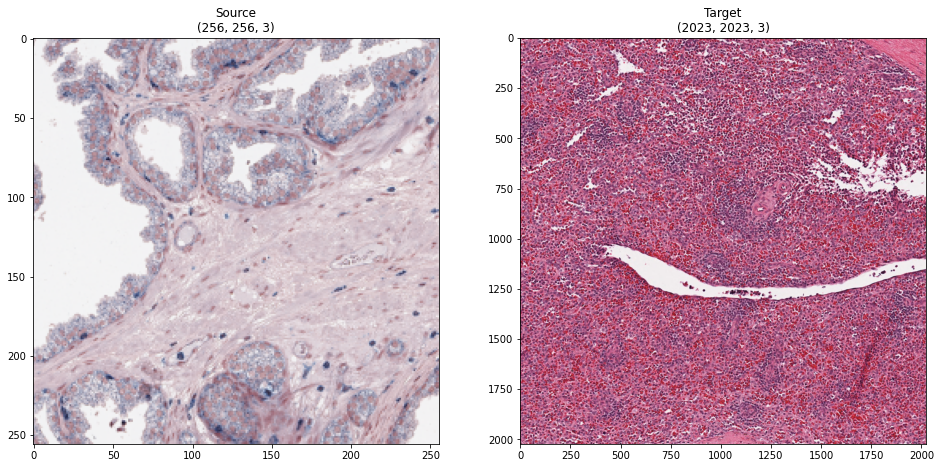

In [8]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title(f"Source\n{source.shape}")
plt.imshow(source)
plt.subplot(122)
plt.title(f'Target\n{target.shape}')
plt.imshow(target)

## *Conventional Techniques*

### Reinhard

Text(0.5, 1.0, 'Reinhard')

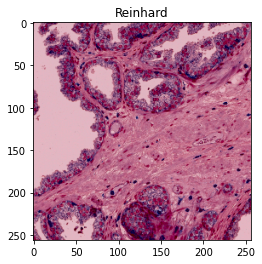

In [9]:
# run reinhard normalization
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(target))
reinhard_normalized = normalizer.transform(np.array(source))
plt.imshow(reinhard_normalized)
plt.title('Reinhard')

### Vahadane

Text(0.5, 1.0, 'Vahadane')

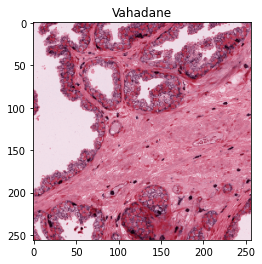

In [10]:
# run vahadane normalization
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(np.array(target))
vahadane_normalized = normalizer.transform(np.array(source))
plt.imshow(vahadane_normalized)
plt.title('Vahadane')

## *Deep Learning Techniques*

### StainGAN

In [11]:
# load pretrained StainGAN
model_GAN = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).cuda()
model_GAN.load_state_dict(torch.load('../input/StainNet/checkpoints/aligned_histopathology_dataset/latest_net_G_A.pth'))

<All keys matched successfully>

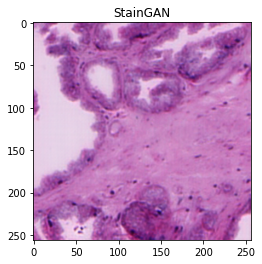

In [12]:
model_GAN.eval()
with torch.no_grad():
    img_gan=model_GAN(norm(source).cuda())
    img_gan=un_norm(img_gan)
    plt.imshow(img_gan)
    plt.title('StainGAN')

## StainNet

In [13]:
# load  pretrained StainNet
model_Net = StainNet().cuda()
model_Net.load_state_dict(torch.load("../input/StainNet/checkpoints/aligned_histopathology_dataset/StainNet-Public_layer3_ch32.pth"))

<All keys matched successfully>

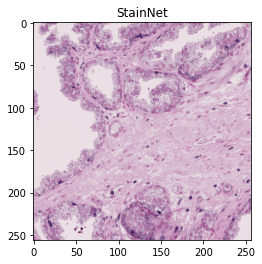

In [14]:
model_Net.eval()
with torch.no_grad():
    img_net=model_Net(norm(source).cuda())
    img_net=un_norm(img_net)
    plt.imshow(img_net)
    plt.title('StainNet')

In [15]:
type(img_net)

numpy.ndarray

<a id="eval"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="eval"><left><br>&nbsp2. EVALUATION <a href="#toc">&#10514;</a><br></left> </h2>

## *Visual Comparison*

In [16]:
normalized_imgs = {'Source': source, 'Target': target, 
                   'Reinhard': reinhard_normalized, 'Vahadane': vahadane_normalized, 
                   'StainGan': img_gan, 'StainNet': img_net}

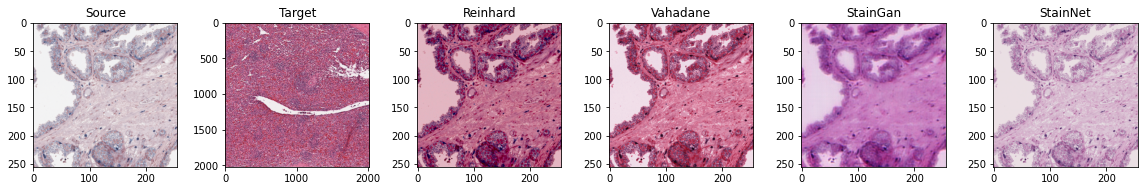

In [17]:
plt.figure(figsize=(16,16))
for i, (method, img) in enumerate(normalized_imgs.items()):
    plt.subplot(1, 6, i+1)
    plt.title(method)
    plt.imshow(img)
plt.tight_layout()
    

## *Evaluation Metrics*

There are 2 types of similarity metrics to evaluate the performance of different methods:

* **[Structural Similarity Index (SSIM)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)**
* **[Peak Signal-to-Noise Ratio (PSNR)](https://scikit-image.org/docs/dev/api/skimage.metrics.html?highlight=structural_similarity#skimage.metrics.peak_signal_noise_ratio)**

The SSIM Source and PSNR Source are used to evaluate the similarity between the normalized image and the source image. The SSIM Source is used to measure the preservation of the source image texture information. 

In [18]:
methods = []
ssim_results = []
psnr_results = []
for i, (method, img) in enumerate(normalized_imgs.items()):
    if i > 1:
        methods.append(method)
        ssim_results.append(ssim(source, img, data_range=img.max() - img.min(), channel_axis=2))
        psnr_results.append(psnr(source, img, data_range=img.max() - img.min()))


In [19]:
evaluation_table = pd.DataFrame(list(zip(methods, ssim_results, psnr_results)), 
                                columns=['Methods', 'SSIM source', 'PSNR source'])
evaluation_table.style.hide_index().apply(highlight([1,3]), axis=1)

Methods,SSIM source,PSNR source
Reinhard,0.824464,10.585443
Vahadane,0.853116,13.133590
StainGan,0.698810,14.680928
StainNet,0.953230,25.783201


=> **StainNet** outperforms other techniques. However, if we want to use a conventional technique instead of a deep-learning-based technique then **Vahadane** is a good to go one.

<a id="dataset"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="dataset"><left><br>&nbsp3. DATASET CREATION <a href="#toc">&#10514;</a><br></left> </h2>

In [ ]:
PATH = '../input/hubmap-256x256/train'
OUT_TRAIN = './normalized.zip'

In [ ]:
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for _,_,files in os.walk(PATH):
        for file_name in files:
            with torch.no_grad():
                source = Image.open(PATH+'/'+file_name) 
                image_net=model_Net(norm(source).cuda())
                image_net=un_norm(image_net)
                im = cv2.imencode('.png',image_net)[1]
                img_out.writestr(f'{file_name}.png', im) 